In [1]:
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

import pandas as pd
import numpy as np
import ipywidgets as widgets
import seaborn as sns

import os
import sys 

In [2]:
data_path="../data/"
df_list=list()
for filename in os.listdir(data_path):
    basename,extension=os.path.splitext(filename)
    if extension != ".csv":
        continue
    df_tmp=pd.read_csv(os.path.join(data_path,filename),names=["Energy (meV)","GDOS","Error"],skiprows=1)
    basename_list=basename.replace(" ","_").split("_")
    if basename_list[0] == "Calc":
        df_tmp["Dataset"]=" ".join(basename_list[2:])
        df_tmp["Kind"]="Simulation"
        df_tmp["Temperature"]=basename_list[1]
    else:
        df_tmp["Dataset"]=",".join(["experimental",basename_list[1]])
        df_tmp["Kind"]="Experiment"
        df_tmp["Temperature"]=basename_list[-1]
        
    df_tmp["GDOS (normalized)"]=df_tmp["GDOS"]/df_tmp["GDOS"].max()
    df_list.append(df_tmp)
        
df_data=pd.concat(df_list,ignore_index=True)
df_data

,Energy (meV),GDOS,Error,Dataset,Kind,Temperature,GDOS (normalized)
0,0.4000,0.000517,0.000003,"experimental,Feb",Experiment,500K,0.037710
1,0.8000,0.001080,0.000009,"experimental,Feb",Experiment,500K,0.078775
2,1.2000,0.001680,0.000014,"experimental,Feb",Experiment,500K,0.122538
3,1.6000,0.002310,0.000020,"experimental,Feb",Experiment,500K,0.168490
4,2.0000,0.002940,0.000024,"experimental,Feb",Experiment,500K,0.214442
...,...,...,...,...,...,...,...
42294,55.9894,0.008550,0.000768,"experimental,Jan",Experiment,300K,0.621366
42295,56.8393,0.008700,0.000721,"experimental,Jan",Experiment,300K,0.632267
42296,57.7075,0.009180,0.000739,"experimental,Jan",Experiment,300K,0.667151
42297,58.5944,0.009590,0.000733,"experimental,Jan",Experiment,300K,0.696948


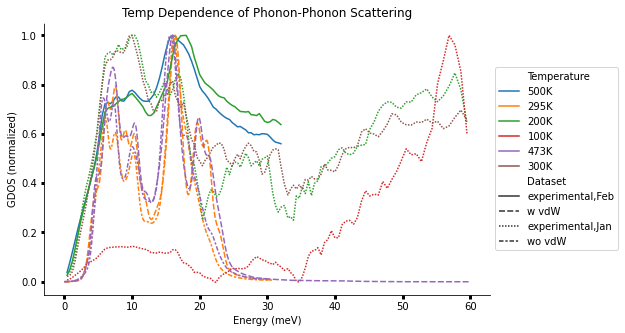

In [3]:
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(data=df_data.query("`Energy (meV)` < 60")
    , x='Energy (meV)'
    , y='GDOS (normalized)'
    ,hue='Temperature'
    ,style="Dataset"
            )
ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('1')
ax.spines['right'].set_color('1')
ax.spines['left'].set_color('0')
ax.tick_params(direction='out', width=3, bottom=True, left=True)
ax.grid(False)
ax.set_title('Temp Dependence of Phonon-Phonon Scattering')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.savefig("../figures/Figure1b.pdf", pad_inches=0.2,bbox_inches="tight")

In [22]:
def gaussian_op(x, mu, τ):
    return np.exp((-np.subtract(x,mu)**2.0)/(2*(τ/2.35)**2))

def apply_blurring(df,A = 0.5,B = 10**-12,C = 10**-12,D = 3,k = 0.15,z = 12,T = 500):
    #B~2*kB^2*gamma^2/ShearModulus*hbar*DebeyeTemp*VolumePerAtom
    #C=VolumePerAtom*ScatteringStrength/4Pi*vg^3
    #D=Intensity of Step function
    #k=Sharpness of Step function
    #z=Position Step function begins
    #T=Temperature
    
    dE = df["Energy (meV)"].diff().mean()
    #define bluring function 
    df["blurring"]=df["Energy (meV)"].apply(lambda x : A + B*T**3*x**2  + C*x**4 + D/(1+np.exp(-2*k*(x-z))))

    #set bluring window
    window_size=np.array(3*df["blurring"]/dE).astype(int)

    df.reset_index(drop=True,inplace=True)
    index=df.index
    index_min=df.index.min()
    index_max=df.index.max()
    window_range=np.array([
        np.clip(index-window_size,index_min,index_max),
        np.clip(index+window_size,index_min,index_max)
    ])
    df_size=df.shape[0]
    gdos_window=np.zeros([df_size,df_size])
    energy_window=np.zeros([df_size,df_size])
    for i,(left,right) in enumerate(window_range.T):
        gdos_window[left:right,i]=df["GDOS"].iloc[left:right]
        energy_window[left:right,i]=df["Energy (meV)"].iloc[left:right]
    gdos_blurred=np.sum(gaussian_op(energy_window,df["Energy (meV)"].values,df["blurring"].values)*np.divide(gdos_window,df["blurring"].values),axis=0)
    df["GDOS (blurred)"]=gdos_blurred/gdos_blurred.max()
    return df

def plot_with_blurred(df
                      ,experiment_dataset
                      ,experiment_temperature
                      ,simulation_dataset
                      ,simulation_temperature
                      ,bluring_temperature
                      ,intensity_step_function
                      ,show_original=True
                     ):

    df_experiment=df_data.query("Temperature == '%s' and Dataset=='%s'"%(experiment_temperature,experiment_dataset))
    if df_experiment.empty:
        print("Empty set")
        return 
    
    df_simulation=apply_blurring(df_data.query("Temperature == '%s' and Dataset=='%s' and `Energy (meV)` < %f"%(simulation_temperature,simulation_dataset,df_experiment["Energy (meV)"].max())).copy()
                                 ,D=intensity_step_function
                                 ,T=bluring_temperature)

    df_simulation.rename(columns={"GDOS (normalized)":"Simulation original","GDOS (blurred)":"Simulation blurred"},inplace=True)
    df_simulation_melted=pd.melt(df_simulation,id_vars="Energy (meV)",value_vars=["Simulation original","Simulation blurred"],var_name="Dataset",value_name="GDOS (normalized)")
    
    
    df_concatenated=pd.concat([df_experiment,df_simulation_melted],ignore_index=True).reset_index(drop=True)
    if not show_original:
        df_concatenated = df_concatenated.query("Dataset != 'Simulation original'")
        
    fig, ax = plt.subplots(figsize=(8,5))
    sns.lineplot(data=df_concatenated
        , x='Energy (meV)'
        , y='GDOS (normalized)'
        ,hue='Dataset'
     )
    ax.spines['bottom'].set_color('0')
    ax.spines['top'].set_color('1')
    ax.spines['right'].set_color('1')
    ax.spines['left'].set_color('0')
    ax.tick_params(direction='out', width=3, bottom=True, left=True)
    ax.grid(False)
    ax.set_title('Experimental T=%s, Simulation T=%s (%s) and Bluring T=%d K'%(
                      experiment_temperature
                      ,simulation_temperature
                      ,simulation_dataset
                      ,bluring_temperature)
                )
    
d=interact(plot_with_blurred,df=fixed(df_data.copy())
         ,experiment_dataset=df_data.query("Kind=='Experiment'")["Dataset"].unique()
         ,experiment_temperature=df_data.query("Kind=='Experiment'")["Temperature"].unique()
         ,simulation_dataset=df_data.query("Kind=='Simulation'")["Dataset"].unique()
         ,simulation_temperature=df_data.query("Kind=='Simulation'")["Temperature"].unique()
        ,bluring_temperature=[100,500,1000]
        ,intensity_step_function=widgets.IntSlider(min=3,max=10)
        )


interactive(children=(Dropdown(description='experiment_dataset', options=('experimental,Feb', 'experimental,Ja…